In [202]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, auc, confusion_matrix

In [ ]:
# Make sure to upload your kaggle.json file to your working directory
# On a local machine, place it in the ~/.kaggle/ directory.

# Download the dataset
!kaggle datasets download -d adrianvinueza/gym-customers-features-and-churn -f gym_churn_us.csv --force

# Read the data from the extracted directory
df = pd.read_csv("gym_churn_us.csv")

# Taking a look in the first rows
print('First rows:')
print(df.head())

Dataset URL: https://www.kaggle.com/datasets/adrianvinueza/gym-customers-features-and-churn
License(s): CC-BY-NC-SA-4.0

First rows:
   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26     


  0%|          | 0.00/314k [00:00<?, ?B/s]
100%|██████████| 314k/314k [00:00<00:00, 332MB/s]


In [204]:
# Data types and non-null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float


> No missing values, NaN and no Dtpe like objects or data to treat


In [205]:
# Descriptive statistics for numeric columns
print(df.describe())

            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00


> It looks like there is **qualitative** info transformed in binary data (eg. gender, partner, promo_friends...) and **quantitative** info (eg. class_frequency, lifetime...).


In [206]:
# Number of unique values per column
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

gender: 2 unique values
Near_Location: 2 unique values
Partner: 2 unique values
Promo_friends: 2 unique values
Phone: 2 unique values
Contract_period: 3 unique values
Group_visits: 2 unique values
Age: 23 unique values
Avg_additional_charges_total: 4000 unique values
Month_to_end_contract: 12 unique values
Lifetime: 29 unique values
Avg_class_frequency_total: 3913 unique values
Avg_class_frequency_current_month: 3820 unique values
Churn: 2 unique values



>This is a classification problem without a time component, so we won’t split data chronologically like in time series forecasting. Instead, we’ll use cross-sectional prediction, which is standard for churn modeling in many industries


In [207]:
# Stratified split on target column (Churn)
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["Churn"],   # preserve class balance
    random_state=42
)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (3200, 14)
Test shape: (800, 14)



>To do inferential statistics / EDA with the target (churn), we should only use the training portion of your dataset. That way, the test set remains “untouched” and unbiased for final evaluation.
>
>And why stratify? To keep the same churn % (~26%) in both train and test.


In [208]:
# Select only numeric columns
num_cols = df_train.select_dtypes(include=["int64", "float64"]).columns

# Correlation matrix
corr = df_train[num_cols].corr()

# Display
print(corr["Churn"].sort_values(ascending=False))  # correlations with target

Churn                                1.000000
Phone                                0.000247
gender                              -0.002066
Near_Location                       -0.133999
Partner                             -0.141815
Promo_friends                       -0.151671
Group_visits                        -0.179666
Avg_additional_charges_total        -0.199066
Avg_class_frequency_total           -0.248078
Month_to_end_contract               -0.378227
Contract_period                     -0.384465
Age                                 -0.407701
Avg_class_frequency_current_month   -0.410389
Lifetime                            -0.436536
Name: Churn, dtype: float64


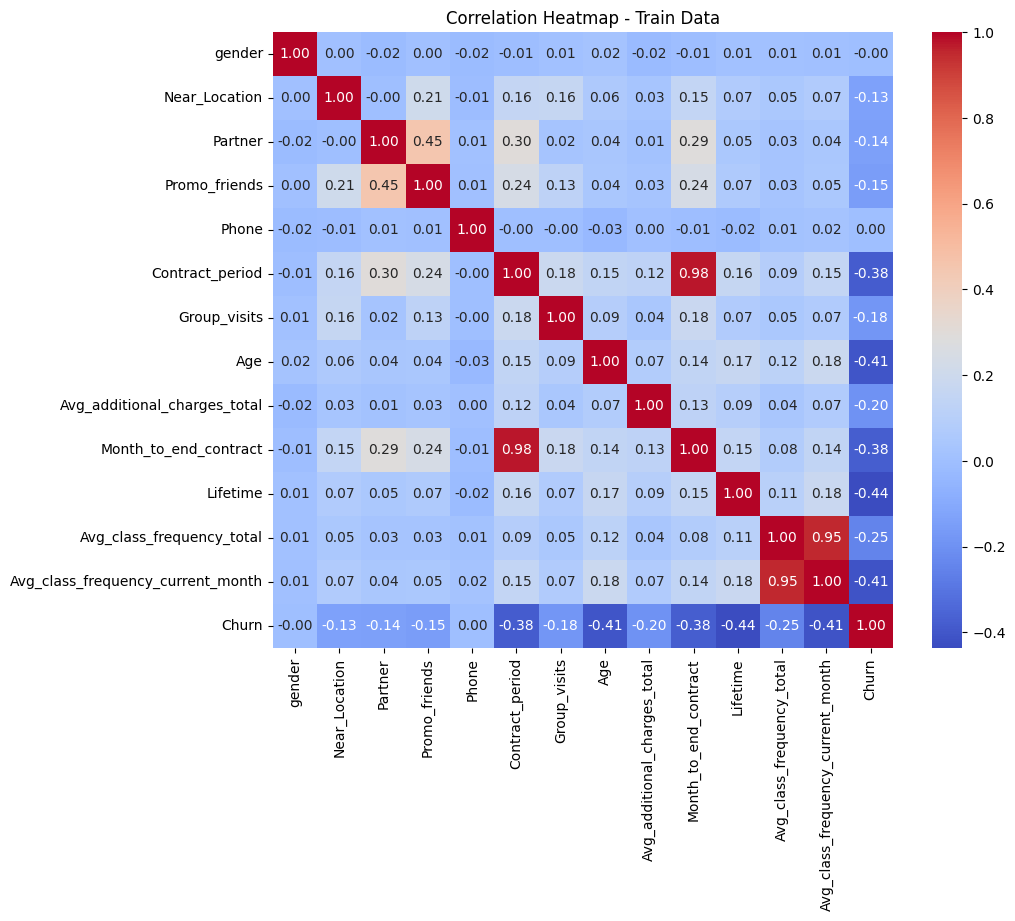

In [209]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap - Train Data")
plt.show()

>
>Behavioral/engagement variables (Lifetime, frequency, contract peiod) are the strongest churn predictors.
>
>Variables like gender or whether the gym has the phone number don’t matter, and we could drop these low-signal features (Phone, gender) to simplify the model.
>
>In the Heatmap we can see the variables 'Month_to_end_contract' and 'Contract_period', 'Avg_class_frequency_current_month' and 'Avg_class_frequency_total' are strongly correlated with each other (multicollinearity), which means that keeping both does not add much new information. Therefore, we could drop one of these features
>

In [210]:
# Training a Decision Tree to show the most important features
x_df_train = df_train.iloc[:, :-1]
y_df_train = df_train.iloc[:,-1]
dtree = tree.DecisionTreeClassifier(random_state=42, max_depth=10)
dtree.fit(x_df_train, y_df_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [211]:
# Returns feature importance
importances = dtree.feature_importances_

# Creates a Dataframe
feat_importances = pd.DataFrame({
    "feature": x_df_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances)

                              feature  importance
10                           Lifetime    0.388240
12  Avg_class_frequency_current_month    0.154403
11          Avg_class_frequency_total    0.151021
9               Month_to_end_contract    0.104443
7                                 Age    0.083852
8        Avg_additional_charges_total    0.048935
5                     Contract_period    0.039205
6                        Group_visits    0.013317
1                       Near_Location    0.006346
3                       Promo_friends    0.005956
0                              gender    0.001673
4                               Phone    0.001501
2                             Partner    0.001107



>Through the Tree Classifier we can have another way to visualize the most important/ correlated features with the target Churn acoording to this model, and if we check against the Heatmap it will confirm that they are the same most important features.


In [212]:
feat_importances['importance_cumsum'] = feat_importances['importance'].cumsum()
print(feat_importances)

                              feature  importance  importance_cumsum
10                           Lifetime    0.388240           0.388240
12  Avg_class_frequency_current_month    0.154403           0.542644
11          Avg_class_frequency_total    0.151021           0.693665
9               Month_to_end_contract    0.104443           0.798108
7                                 Age    0.083852           0.881960
8        Avg_additional_charges_total    0.048935           0.930895
5                     Contract_period    0.039205           0.970100
6                        Group_visits    0.013317           0.983417
1                       Near_Location    0.006346           0.989764
3                       Promo_friends    0.005956           0.995719
0                              gender    0.001673           0.997392
4                               Phone    0.001501           0.998893
2                             Partner    0.001107           1.000000



>We could use as features for the model, only those that contributes up to 95% of the total sum of importance, for example.


In [213]:
feat_importances[feat_importances['importance_cumsum'] < 0.95]

,feature,importance,importance_cumsum
10,Lifetime,0.388240,0.388240
12,Avg_class_frequency_current_month,0.154403,0.542644
11,Avg_class_frequency_total,0.151021,0.693665
9,Month_to_end_contract,0.104443,0.798108
7,Age,0.083852,0.881960
8,Avg_additional_charges_total,0.048935,0.930895


In [214]:
best_features = feat_importances[feat_importances['importance_cumsum'] < 0.95]['feature'].tolist()

best_features

['Lifetime',
 'Avg_class_frequency_current_month',
 'Avg_class_frequency_total',
 'Month_to_end_contract',
 'Age',
 'Avg_additional_charges_total']

In [215]:
# Create and train the model
logr = LogisticRegression(random_state=42, max_iter=1000, penalty=None)
logr.fit(x_df_train[best_features], y_df_train)

LogisticRegression(max_iter=1000, penalty=None, random_state=42)

In [216]:
# Train predictions
y_train_pred = logr.predict(x_df_train[best_features])
y_train_proba = logr.predict_proba(x_df_train[best_features])[:, 1]  # positive class probability

x_df_test = df_test.iloc[:, :-1]
y_df_test = df_test.iloc[:,-1]

# Test predictions
y_test_pred = logr.predict(x_df_test[best_features])
y_test_proba = logr.predict_proba(x_df_test[best_features])[:, 1]  # positive class probability

In [217]:
def evaluate_model(y_true, y_pred, y_proba, name):
    """Calculates and prints key model metrics."""
    acc = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr, re, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(re, pr)

    print(f"\n🔹 {name}:")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   AUC: {auc_score:.4f}")
    print(f"   PR-AUC: {pr_auc:.4f}")

# Then, you just call the function for each dataset
evaluate_model(y_df_train, y_train_pred, y_train_proba, "TRAIN")
evaluate_model(y_df_test, y_test_pred, y_test_proba, "TEST")


🔹 TRAIN:
   Accuracy: 0.9256
   Precision: 0.8795
   Recall: 0.8339
   F1-Score: 0.8561
   AUC: 0.9755
   PR-AUC: 0.9451

🔹 TEST:
   Accuracy: 0.9300
   Precision: 0.8980
   Recall: 0.8302
   F1-Score: 0.8627
   AUC: 0.9740
   PR-AUC: 0.9453


>
>**Accuracy (Train: 92.56%, Test: 93.00%)**
>
>Accuracy measures the proportion of correctly predicted instances (both churn and non-churn) out of the total instances. The model is highly accurate, correctly classifying over 90% of customers on both your training and test data. It is a straightforward and intuitive metric, but it can be misleading in cases of imbalanced datasets (where one class is significantly more frequent than the other).
>
>**Precision (Train: 87.95%, Test: 89.80%)**
>
>Precision answers the question: "Of all the customers the model predicted would churn, what percentage actually did?" A high precision means the model has a low rate of false positives—it's not incorrectly flagging many non-churning customers as "at-risk." This is good for avoiding unnecessary and potentially costly retention efforts.
>
>**Recall (Train: 83.39%, Test: 83.02%)**
>
>Recall answers the question: "Of all the customers who actually churned, what percentage did the model correctly identify?" A high recall means the model is effective at catching a high proportion of the real churners. This is crucial for a churn model because missing a customer who is about to churn (a false negative) is often a costly mistake.
>
>**F1-Score (Train: 85.61%, Test: 86.27%)**
>
>The F1-score is a weighted average of precision and recall. It's a great single metric for evaluating the model when you need a balance between the two. The model has a strong F1-score on both datasets, indicating it has a good balance of catching churners without too many false alarms.
>
>**AUC (Area Under the Curve) (Train: 97.55%, Test: 97.40%)**
>
>This metric measures the model's ability to distinguish between the two classes (churn vs. non-churn) across all possible classification thresholds. An AUC of 1.0 is a perfect model, while 0.5 is no better than random guessing. The very high AUC scores indicate that the model is excellent at ranking customers by their likelihood of churning.
>
>**PR-AUC (Area Under the Precision-Recall Curve) (Train: 94.51%, Test: 94.53%)**
>
>The PR-AUC focuses specifically on the model's performance on the positive class (churners). This metric is often more informative than the standard AUC when the dataset is imbalanced, as it's not influenced by the number of true negatives. The high PR-AUC scores show that your model is highly effective at identifying churners with a great balance of precision and recall.
>
>**Overall Model Performance**
>The model shows good performance on both the training and test sets. The metrics are consistent between the two sets, which is a strong sign that the model is not overfitting. The slight increase in accuracy on the test set is a positive sign of good generalization. The high scores across all key metrics—especially AUC and PR-AUC—indicate that the model is very robust and reliable for predicting customer churn.
>

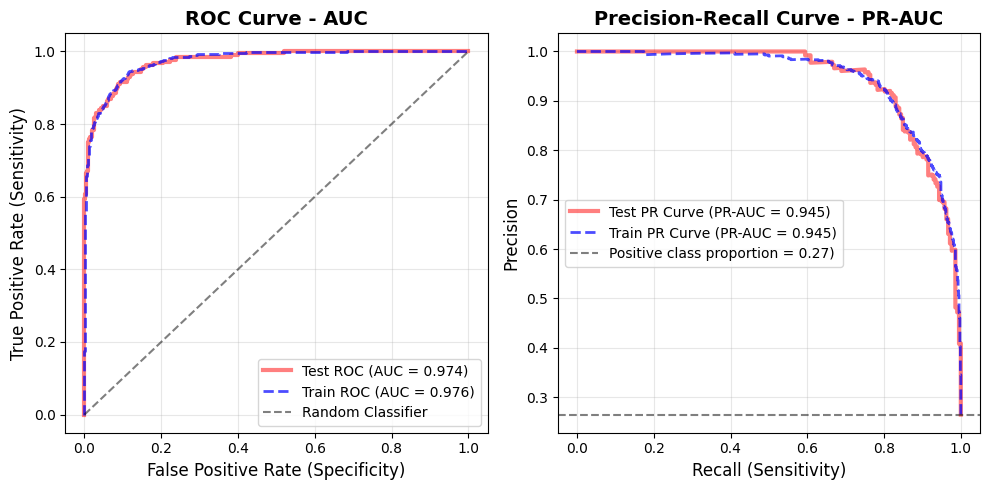

In [218]:
# Set up the plotting style
plt.style.use('default')

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ==================== ROC Curve Plot (ax1) ====================
# Calculate ROC curve for both train and test set
fpr_train, tpr_train, _ = roc_curve(y_df_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_df_test, y_test_proba)

# Plot ROC curves
ax1.plot(fpr_test, tpr_test, linewidth=3, label=f'Test ROC (AUC = {auc_test:.3f})', color='red', alpha=0.5)
ax1.plot(fpr_train, tpr_train, linewidth=2, label=f'Train ROC (AUC = {auc_train:.3f})',
         color='blue', alpha=0.7, linestyle='--')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

ax1.set_xlabel('False Positive Rate (Specificity)', fontsize=12)
ax1.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
ax1.set_title('ROC Curve - AUC', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)


# ==================== Precision-Recall Curve Plot (ax2) ====================
# Calculate PR curve for both train and test set
precision_train, recall_train, _ = precision_recall_curve(y_df_train, y_train_proba)
precision_test, recall_test, _ = precision_recall_curve(y_df_test, y_test_proba)

# Calculate PR-AUC for both train and test set
pr_auc_train = auc(recall_train, precision_train)
pr_auc_test = auc(recall_test, precision_test)

# Calculate the baseline for a random classifier on the test set
pos_ratio = np.sum(y_df_test == 1) / len(y_df_test)

# Plot PR curves
ax2.plot(recall_test, precision_test, linewidth=3, label=f'Test PR Curve (PR-AUC = {pr_auc_test:.3f})', color='red', alpha=0.5)
ax2.plot(recall_train, precision_train, linewidth=2, label=f'Train PR Curve (PR-AUC = {pr_auc_train:.3f})',
         color='blue', alpha=0.7, linestyle='--')

# Plot the positive class (churn) proportion
ax2.axhline(y=pos_ratio, color='k', linestyle='--', alpha=0.5, label=f'Positive class proportion = {pos_ratio:.2f})')

ax2.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve - PR-AUC', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)


plt.tight_layout()
plt.savefig('ROC_PR-Curve.png', dpi=300, bbox_inches='tight')

>**ROC Curve Analysis**
>
>The Receiver Operating Characteristic (ROC) curve is a graphical representation of a classification model's performance across all possible classification thresholds.
>
>**Interpreting the ROC Curve**
>
>The ideal ROC curve hugs the top-left corner of the plot, indicating a high TPR and a low FPR across all thresholds. The dashed diagonal line represents a random classifier, which has an AUC of 0.5. Any curve above this line indicates a better-than-random classifier.
>
>The fact that both the train and test ROC curves are nearly identical and both are very close to the top-left corner is a strong indicator of a well-performing and robust model.
>
>**Precision-Recall (PR) Curve Analysis**
>
>The Precision-Recall (PR) curve is another crucial graphical metric, especially useful for evaluating models on imbalanced datasets, such as this one. While the ROC curve assesses the model's overall discriminatory ability, the PR curve focuses on its performance on the minority class (churn).
>
>**Interpreting the PR Curve**
>
>The ideal PR curve approaches the top-right corner of the plot. This represents a model with high Precision (few false positives) and high Recall (few false negatives). The dashed horizontal line represents the positive class proportion. Any curve above this baseline indicates that the model is learning to identify the minority class better than random chance.
>
>The proximity of the train and test curves, and the shape of both, which remain close to the top-right of the plot, are positive signs. They show that the model has a robust and consistent ability to identify customers who will truly churn with high precision and without missing many cases, validating its effectiveness even in a scenario with imbalanced classes. The nearly perfect overlap of the train and test curves reinforces that your model is not suffering from overfitting, generalizing well to new data.
>

### Business Implications and Actionable Insights: Translating Predictions into Retention Strategies ###

>
>One os the most importante feature in the model is Avg_class_frequency, but waiting for a clear indicator like a significant drop in attendance frequency might be too late. By then, the member might have already disengaged, found an alternative, or simply lost motivation to the point where re-engagement efforts are less effective or more costly. The power of your predictive model is its ability to identify members before these overt signs of disengagement become critical.
>
>The model provides a churn probability score for each member. This score is the key to proactive intervention:
>
>• Early Warning System: Members with a high churn probability, even if their attendance hasn't drastically dropped yet, can be flagged for early intervention.
>
>• Targeted Campaigns: Instead of broad, untargeted retention efforts, the model allows the gym to focus resources on those members who are most at risk.
>



>
>Logistic regression, by default, assigns an instance to the positive class (churn, in that case) if its predicted probability is greater than or equal to 0.5, and to the negative class (no churn) otherwise. This threshold is chosen because it minimizes the overall misclassification rate when the classes are balanced and the costs of false positives and false negatives are equal.
>
>The cut threshold should be determined by the business objectives and the relative costs of different types of errors, and the default 0.5 is not allways the best fit.
>
>The Trade-off: Sensitivity vs. Specificity (or Precision):
>
>- Lowering the threshold (e.g., from 0.5 to 0.3) increases Sensitivity (you catch more true churners) but decreases Specificity (you might incorrectly flag more non-churners as churners, leading to more false positives).
>
>- Raising the threshold (e.g., from 0.5 to 0.7) increases Specificity (you are more confident that flagged customers will churn) but decreases Sensitivity (you might miss more true churners).
>

In [219]:
# --- Cost-Sensitivity Analysis and Optimal Threshold Calculation ---

# Defining the costs and churn rate based on your scenario
# Cost to retain a customer (intervention cost) = x
# Cost to acquire a new customer = 3x

fp_cost=1
fn_cost=3

thresholds = np.linspace(0, 1, 11)  # 0.00 to 1.00 in steps of 0.1
records = []

for t in thresholds:
    y_pred = (y_test_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_df_test, y_pred).ravel()
    cost = fp * fp_cost + fn * fn_cost
    total = tn + fp + fn + tp
    
    records.append([t, cost, tp, fp, tn, fn, total])

df_thresholds = pd.DataFrame(records, columns=["threshold", "cost", "TP", "FP", "TN", "FN", "total"])

# Find best threshold
best_row = df_thresholds.loc[df_thresholds["cost"].idxmin()]
print(df_thresholds)
print("\nBest threshold row:\n", best_row)

    threshold  cost   TP   FP   TN   FN  total
0         0.0   588  212  588    0    0    800
1         0.1   118  203   91  497    9    800
2         0.2   112  194   58  530   18    800
3         0.3   120  186   42  546   26    800
4         0.4   128  180   32  556   32    800
5         0.5   128  176   20  568   36    800
6         0.6   133  173   16  572   39    800
7         0.7   155  164   11  577   48    800
8         0.8   189  151    6  582   61    800
9         0.9   252  129    3  585   83    800
10        1.0   636    0    0  588  212    800

Best threshold row:
 threshold      0.2
cost         112.0
TP           194.0
FP            58.0
TN           530.0
FN            18.0
total        800.0
Name: 2, dtype: float64


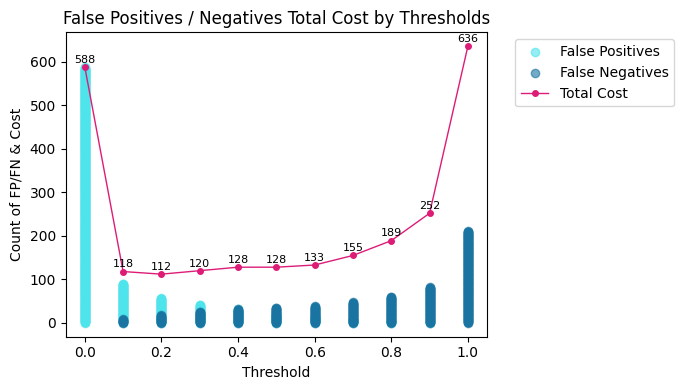

In [220]:
plt.figure(figsize=(7,4))

# Scatter "dot cloud" for FP and FN
for i, row in df_thresholds.iterrows():
    fp = int(row["FP"])
    fn = int(row["FN"])
    thr = float(row["threshold"])
    
    # FP dots
    plt.scatter(
        [thr] * fp,              # repeat threshold fp times
        np.arange(fp),           # stacked dots vertically
        color="#4de4ec", alpha=0.6, label="False Positives" if i == 0 else ""
    )
    
    # FN dots
    plt.scatter(
        [thr] * fn,
        np.arange(fn),
        color="#1974a1", alpha=0.6, label="False Negatives" if i == 0 else "",
    )

# Cost line
plt.plot(df_thresholds["threshold"], df_thresholds["cost"], 
         color="#dd1c77", linewidth=1, label="Total Cost", marker="o", markersize=4)

for x, y in zip(df_thresholds["threshold"], df_thresholds["cost"]):
    plt.text(x, y + 5, f"{y:.0f}", ha="center", va="bottom", fontsize=8)

# Formatting
plt.xlabel("Threshold")
plt.ylabel("Count of FP/FN & Cost")
plt.title("False Positives / Negatives Total Cost by Thresholds")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



>**Conclusion: Optimal Threshold for Business Impact**
>
>This analysis reveals that while the model's high performance is consistent across multiple thresholds, the default 0.5 value could not be the most strategic choice for the business. Considering for example a false positive costs = 1x and false negative cost = 3x, we have identified the optimal threshold at 0.2, which minimizes the total financial cost.
>
>However, given the minimal cost difference between the 0.2 and 0.6 thresholds, there could be a business decision to make:
>
>Option 1: The Aggressive Approach (Threshold < 0.5): By lowering the threshold to 0.2, we cast a wider net to capture more at-risk customers (reducing costly false negatives). This is the ideal choice if we have the operational capacity to engage a larger segment of members with proactive retention campaigns.
>
>Option 2: The Balanced Approach (Threshold = 0.5): Sticking with the default threshold is a defensible and easily communicated strategy. It focuses our efforts on the most likely churners (those with a 50%+ probability), ensuring that our retention resources are used with high precision.
>
>Option 3: The Conservative Approach (Threshold > 0.5): If our resources are limited, we could raise the threshold, only targeting the highest-probability churners. This would reduce the number of interventions, minimizing wasted effort, though at the cost of missing some at-risk customers.
>
>This optimization process transforms the model from a simple predictive tool into a cost-sensitive decision-making system. It allows us to directly translate statistical findings into a strategic, data-driven plan that aligns with the company's business financial goals and resource availability.